Import the libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

Load the dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Data/processed_data.csv")
df.head()

,product,subproduct,issue,subissue,narrative,narrative_tokens
0,credit_reporting,Credit reporting,Incorrect information on your report,Information belongs to someone else,hi submitting isnt influence third party trans...,"['hi', 'submitting', 'isnt', 'influence', 'thi..."
1,mortgages_and_loans,Other type of mortgage,Applying for a mortgage or refinancing an exis...,None,applied preapproval property order able view s...,"['applied', 'preapproval', 'property', 'order'..."
2,credit_reporting,Credit reporting,Problem with a credit reporting company's inve...,Problem with personal statement of dispute,investigation found information disputed inacc...,"['investigation', 'found', 'information', 'dis..."
3,credit_reporting,Credit reporting,Improper use of your report,Reporting company used your report improperly,accordance fair credit reporting act violated ...,"['accordance', 'fair', 'credit', 'reporting', ..."
4,debt_collection,Other debt,Attempts to collect debt not owed,Debt is not yours,address credit reporting company tx dear cfpb ...,"['address', 'credit', 'reporting', 'company', ..."


In [3]:
df.shape

(387120, 6)

In [4]:
#No of words column
df['narrative'] = df['narrative'].astype(str)
df['num_words'] = df['narrative'].apply(lambda x: len(x.split()))

In [5]:
#Ecoding the target
encoded_dict  ={'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2,
               'credit_card': 3, 'retail_banking': 4}
df['product'].replace(encoded_dict , inplace=True)
df['product'].unique()

array([0, 2, 1, 4, 3])

In [6]:
# Creating a sample of data
df = df.groupby('product').sample(n=10000)
df = df.reset_index(drop=True)

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00


Load Model and Tokenizer

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel

In [9]:
df_train, df_validation = train_test_split(df, test_size=0.15, random_state=42,
                                     stratify=df['product'])
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42,
                                     stratify=df_train['product'])

In [10]:
print(df_train.shape)
df_train['product'].value_counts()

(34000, 7)


4    6800
3    6800
0    6800
1    6800
2    6800
Name: product, dtype: int64

In [11]:
print(df_validation.shape)
df_validation['product'].value_counts()

(7500, 7)


1    1500
2    1500
4    1500
0    1500
3    1500
Name: product, dtype: int64

In [12]:
print(df_test.shape)
df_test['product'].value_counts()

(8500, 7)


0    1700
2    1700
4    1700
1    1700
3    1700
Name: product, dtype: int64

In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:
df['num_words'].max()

2624

In [17]:
max_len = 128

In [18]:
X_train = tokenizer(
    text=df_train['narrative'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_validation = tokenizer(
    text=df_validation['narrative'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Model Fitting

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [20]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [21]:
embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(5, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [22]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

In [23]:
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

In [24]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

In [25]:
history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['product']),
    validation_data = ({'input_ids':X_validation['input_ids'], 'attention_mask':X_validation['attention_mask']},
                        to_categorical(df_validation['product'])),
    epochs=5,
    batch_size=32
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1063/1063 [==============================] - 983s 902ms/step - loss: 0.5614 - balanced_accuracy: 0.8105 - val_loss: 0.4297 - val_balanced_accuracy: 0.8559
Epoch 2/5
1063/1063 [==============================] - 957s 901ms/step - loss: 0.4309 - balanced_accuracy: 0.8569 - val_loss: 0.4143 - val_balanced_accuracy: 0.8639
Epoch 3/5
1063/1063 [==============================] - 957s 900ms/step - loss: 0.4034 - balanced_accuracy: 0.8675 - val_loss: 0.4058 - val_balanced_accuracy: 0.8689
Epoch 4/5
1063/1063 [==============================] - 957s 900ms/step - loss: 0.3834 - balanced_accuracy: 0.8736 - val_loss: 0.4027 - val_balanced_accuracy: 0.8680
Epoch 5/5
1063/1063 [==============================] - 957s 900ms/step - loss: 0.3689 - balanced_accuracy: 0.8772 - val_loss: 0.3997 - val_balanced_accuracy: 0.8717


In [26]:
history.history.keys()

dict_keys(['loss', 'balanced_accuracy', 'val_loss', 'val_balanced_accuracy'])

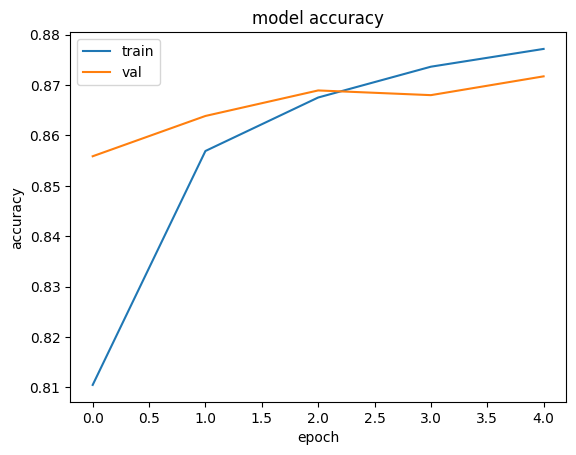

In [27]:
plt.plot(history.history['balanced_accuracy'])
plt.plot(history.history['val_balanced_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

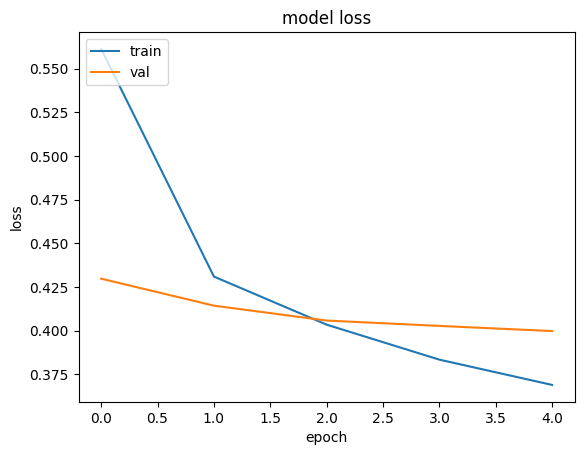

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Evaluation

In [29]:
X_test = tokenizer(
    text=df_test['narrative'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [34]:
from sklearn.metrics import classification_report

In [ ]:
#Accuracy on train data
predicted = model.predict({'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)

In [35]:
print(classification_report(df_train['product'], y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6800
           1       0.87      0.87      0.87      6800
           2       0.92      0.92      0.92      6800
           3       0.89      0.86      0.87      6800
           4       0.91      0.94      0.92      6800

    accuracy                           0.90     34000
   macro avg       0.90      0.90      0.90     34000
weighted avg       0.90      0.90      0.90     34000



In [36]:
#Accuracy on validation data
from sklearn.metrics import classification_report

predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(df_test['product'], y_predicted))

266/266 [==============================] - 73s 276ms/step
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1700
           1       0.83      0.82      0.82      1700
           2       0.89      0.88      0.89      1700
           3       0.86      0.81      0.83      1700
           4       0.87      0.92      0.89      1700

    accuracy                           0.86      8500
   macro avg       0.86      0.86      0.86      8500
weighted avg       0.86      0.86      0.86      8500



In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [38]:
import joblib

In [39]:
joblib.dump(model, '/content/drive/MyDrive/Data/fine_tuned_bert2.joblib')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


['/content/drive/MyDrive/Data/fine_tuned_bert2.joblib']